# TuSimple dataset preparation for lane detection

## Dataset Description
The lane marking is the main component on the highway. It instructs the vehicles interactively and safely drive on the highway. Lane detection is a critical task in autonomous driving, which provides localization information to the control of the car. We provide video clips for this task, and the last frame of each clip contains labelled lanes. The video clip can help algorithms to infer better lane detection results.

## Dataset Size
3626 video clips, 3626 labelled frames. <br>
Information of each clip: 20 frames for each one.

## Directory Structure:
   		|
   		|----readme.md  				# description
   		|
   		|----clips/ 					# video clips, 3626 clips
   		|------|
   		|------|----some_clip/			# Sequential images for the clip, 20 frames
   		|------|----...
   		|
   		|----label_data_0313.json			# Label data for lanes
   		|----label_data_0531.json			# Label data for lanes
   		|----label_data_0601.json			# Label data for lanes

## Label Data Format
Each json line in 'label_data.json' is the label data for __the last (20th) frame__ of this clip.

__Format__

```
    {
      'raw_file': str. Clip file path.
      'lanes': list. A list of lanes. For each list of one lane, the elements are width values on image.
      'h_samples': list. A list of height values corresponding to the 'lanes', which means len(h_samples) == len(lanes[i])
    }
```
Actually there will be at most 5 lane markings in `lanes`. We expect at most 4 lane markings (current lane and left/right lanes). The extra lane is used when changing lane because it is confused to tell which lane is the current lane.

The polylines are orgnized by the same distance gap ('h_sample' in each label data) from the recording car. It means you can pair each element in one lane and h_samples to get position of lane marking on images.

Also, the lanes are around the center of sight, which we encourage the autonomous driving vehicle to focus on the current lane and left/right lanes. These lanes are essential for the control of the car.

For example,
```
{
  "lanes": [
        [-2, -2, -2, -2, 632, 625, 617, 609, 601, 594, 586, 578, 570, 563, 555, 547, 539, 532, 524, 516, 508, 501, 493, 485, 477, 469, 462, 454, 446, 438, 431, 423, 415, 407, 400, 392, 384, 376, 369, 361, 353, 345, 338, 330, 322, 314, 307, 299],
        [-2, -2, -2, -2, 719, 734, 748, 762, 777, 791, 805, 820, 834, 848, 863, 877, 891, 906, 920, 934, 949, 963, 978, 992, 1006, 1021, 1035, 1049, 1064, 1078, 1092, 1107, 1121, 1135, 1150, 1164, 1178, 1193, 1207, 1221, 1236, 1250, 1265, -2, -2, -2, -2, -2],
        [-2, -2, -2, -2, -2, 532, 503, 474, 445, 416, 387, 358, 329, 300, 271, 241, 212, 183, 154, 125, 96, 67, 38, 9, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
        [-2, -2, -2, 781, 822, 862, 903, 944, 984, 1025, 1066, 1107, 1147, 1188, 1229, 1269, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2]
       ],
  "h_samples": [240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710],
  "raw_file": "path_to_clip"
}
```
`-2` in `lanes` means on some h_sample, there is no existing lane marking. The first existing point in the first lane is `(632, 280)`.


In [1]:
# import required libraries/dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import os
import shutil

---

In [2]:
# create the directory for storing the new dataset
!mkdir tusimple_preprocessed
!cd tusimple_preprocessed && mkdir training
!cd tusimple_preprocessed/training && mkdir frames && mkdir lane-masks

In [3]:
'''
In 'clips' directory, we get the 20th frame from each video clip
and copy the image/frame to a new directory of which path is assigned to the variable 'new_frames' below.
'''
clips = '/kaggle/input/tusimple/TUSimple/train_set/clips/'
new_frames = '/kaggle/working/tusimple_preprocessed/training/frames'

for i in os.listdir(clips):
    for j in os.listdir(os.path.join(clips, i)):
        # get the 20th frame
        frame = os.path.join(clips, i, j, '20.jpg')
        '''
            create a new name for each frame: here the directories' names
            e.g. 'clips/0531/1492629775931278791/20.jpg' becomes  '0531_1492629775931278791.jpg'
        '''
        tmp = frame[:-7].split('/')[-2:]
        new_fn = f'{tmp[0]}_{tmp[1]}.jpg'
        new_file = os.path.join(new_frames, new_fn)
        shutil.copy(frame, new_file)
    print('Done with: ', i)

Done with:  0531
Done with:  0601
Done with:  0313-2
Done with:  0313-1


In [4]:
# utils

def generate_lane_mask(row, training_set=True):
    '''
        Generates and writes the corresponding lane masks for the given images
    '''
    # create a mask of all zeros
    mask = np.zeros((720, 1280, 3))
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask: lane: 1, non-lane: 0
    for lane in lanes:    
        '''
        -2 indicates no line in the specified point, so we omit the points from lane markings list
        ''' 
        h_samples_updated = [y for x, y in zip(lane, h_samples) if x != -2]
        lane = [x for x in lane if x != -2]
        lane_points = np.array(list(zip(lane, h_samples_updated)))
        # add lane markings to the mask we created
        cv2.polylines(mask, [lane_points], False, (255, 255, 255), thickness=15)
        
        # write the lane mask to the desired directory
        if training_set:   
            path = '/kaggle/working/tusimple_preprocessed/training/lane-masks'
        else:
            path = '/kaggle/working/tusimple_preprocessed/test/lane-masks'
        '''
            name each mask according to its image's name. 
            e.g. 'clips/0531/1492629775931278791/20.jpg' becomes '0531_1492629775931278791.jpg'
        '''
        tmp = raw_file[:-7].split('/')[-2:]
        mask_fname = f'{tmp[0]}_{tmp[1]}.jpg'
        new_file = os.path.join(path, mask_fname)
        cv2.imwrite(new_file, mask)
    return mask_fname

In [5]:
# load the datasets: json files: label data files
df_0601 = pd.read_json('/kaggle/input/tusimple/TUSimple/train_set/label_data_0601.json', lines=True)
df_0313 = pd.read_json('/kaggle/input/tusimple/TUSimple/train_set/label_data_0313.json', lines=True)
df_0531 = pd.read_json('/kaggle/input/tusimple/TUSimple/train_set/label_data_0531.json', lines=True)
df = pd.concat([df_0601, df_0313, df_0531])

In [6]:
# generate masks based on the json files above
for index, row in df.iterrows():
    # generate the lane mask for each frame
    generate_lane_mask(row)
    if index%200 == 0:
        print('Row: ', index)

Row:  0
Row:  200
Row:  400
Row:  0
Row:  200
Row:  400
Row:  600
Row:  800
Row:  1000
Row:  1200
Row:  1400
Row:  1600
Row:  1800
Row:  2000
Row:  2200
Row:  2400
Row:  2600
Row:  2800
Row:  0
Row:  200


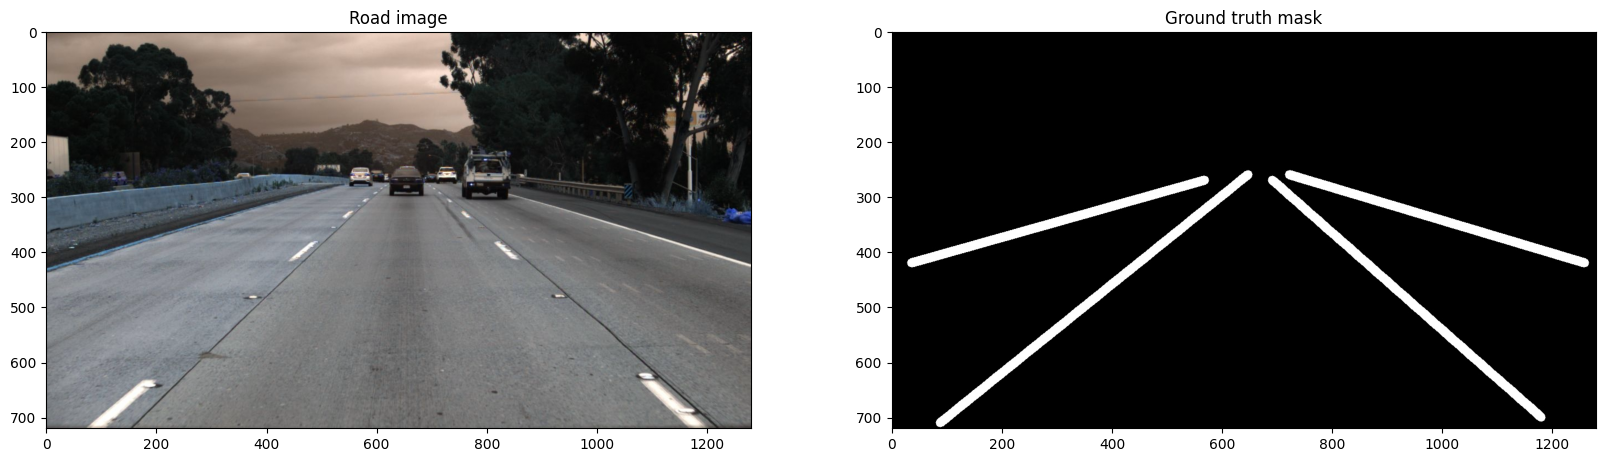

In [7]:
# visualize an example image and its corresponding lane mask
img_mask = cv2.imread('/kaggle/working/tusimple_preprocessed/training/lane-masks/0601_1494453497604532231.jpg')
img_color = cv2.imread('/kaggle/working/tusimple_preprocessed/training/frames/0601_1494453497604532231.jpg')

# training set
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_color/255.)
plt.title('Road image')

plt.subplot(1, 2, 2)
plt.imshow(img_mask/255., cmap='gray')
plt.title('Ground truth mask')



plt.show()

In [8]:
# check if we have the same image-mask pairs in the training set
images_path = '/kaggle/working/tusimple_preprocessed/training/frames'
masks_path = '/kaggle/working/tusimple_preprocessed/training/lane-masks'
assert os.listdir(images_path) == os.listdir(masks_path)

---

In [15]:
# zip the training folder
!zip -r -q training.zip /kaggle/working/tusimple_preprocessed/training

---

The notebook is authored by: [Hikmatullah Mohammadi](https://www.linkedin.com/in/hikmatullah-mohammadi-871550225/)